In [1]:
import torch
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.visualizer import Visualizer
from detectron2.engine import DefaultTrainer
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import warnings
# These warnings are not impactful on the output
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message=".*incompatible shapes.*")

In [2]:
# # this block is used when changing the registered dataset
#
# from detectron2.data import MetadataCatalog
# # remove metadata of dataset from registry
# MetadataCatalog.remove("barnacle_train")

In [3]:
# Register dataset
register_coco_instances(
    "barnacle_train",
    {},
    "barnacle_dataset/annotations/train.json",  # COCO-style annotations (see below)
    "barnacle_dataset/train/images"  # Path to image directory
)

In [4]:
# create config
cfg = get_cfg()

# load base from model zoo
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))

# dataset config
cfg.DATASETS.TRAIN = ("barnacle_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 1

# model config
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1 # Only barnacle class
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256

# memory optimization
cfg.TEST.DETECTIONS_PER_IMAGE = 3000  # Increased to handle dense clusters
cfg.MODEL.RPN.PRE_NMS_TOPK_TRAIN = 5000
cfg.MODEL.RPN.POST_NMS_TOPK_TRAIN = 5000
cfg.SOLVER.AMP.ENABLED = True  # Automatic Mixed Precision
torch.cuda.empty_cache()


# Training Configuration
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00005
cfg.SOLVER.MAX_ITER = 4000
cfg.SOLVER.STEPS = [2500, 3500]
cfg.SOLVER.GAMMA = 0.1

# Warmup Configuration
cfg.SOLVER.WARMUP_FACTOR = 1.0 / 1000
cfg.SOLVER.WARMUP_ITERS = 100
cfg.SOLVER.WARMUP_METHOD = "linear"

# Gradient Clipping
cfg.SOLVER.CLIP_GRADIENTS.ENABLED = True
cfg.SOLVER.CLIP_GRADIENTS.CLIP_TYPE = "norm"
cfg.SOLVER.CLIP_GRADIENTS.CLIP_VALUE = 1.0

In [5]:
# Start training
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[01/28 18:25:44 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

[01/28 18:25:46 d2.engine.train_loop]: Starting training from iteration 0


C:\Users\Aryan Bawa\PyCharmMiscProject\.venv\Lib\site-packages\torch\functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
C:\Users\Aryan Bawa\PyCharmMiscProject\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


[01/28 18:26:17 d2.utils.events]:  eta: 0:25:03  iter: 19  total_loss: 5.12  loss_cls: 0.6837  loss_box_reg: 0.3386  loss_mask: 0.694  loss_rpn_cls: 2.732  loss_rpn_loc: 0.4536    time: 1.2659  last_time: 2.5167  data_time: 0.2450  last_data_time: 0.0039   lr: 1.9131e-05  max_mem: 7199M
[01/28 18:26:37 d2.utils.events]:  eta: 0:23:02  iter: 39  total_loss: 2.491  loss_cls: 0.579  loss_box_reg: 0.4084  loss_mask: 0.6802  loss_rpn_cls: 0.4574  loss_rpn_loc: 0.3764    time: 1.1148  last_time: 0.2212  data_time: 0.0020  last_data_time: 0.0008   lr: 3.9111e-05  max_mem: 7199M
[01/28 18:27:01 d2.utils.events]:  eta: 0:24:39  iter: 59  total_loss: 2.257  loss_cls: 0.5165  loss_box_reg: 0.357  loss_mask: 0.6454  loss_rpn_cls: 0.4012  loss_rpn_loc: 0.3637    time: 1.1492  last_time: 1.1366  data_time: 0.0020  last_data_time: 0.0013   lr: 5.9091e-05  max_mem: 7360M
[01/28 18:27:27 d2.utils.events]:  eta: 0:25:07  iter: 79  total_loss: 2.088  loss_cls: 0.4686  loss_box_reg: 0.3721  loss_mask: 0.6

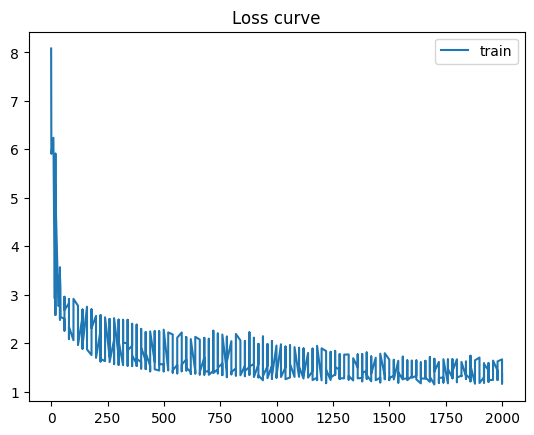

In [16]:
# plot the training loss
metrics_df = pd.read_json("./output/metrics.json", orient="records", lines=True)
mdf = metrics_df.sort_values("iteration")
mdf.head(10).T
fig, ax = plt.subplots()
mdf1 = mdf[~mdf["total_loss"].isna()]
ax.plot(mdf1["iteration"], mdf1["total_loss"], c="C0", label="train")
# ax.set_ylim([0, 3])
ax.legend()
ax.set_title("Loss curve")

# #Save the plot as an image file
# plt.savefig("loss_curve.png")

plt.show()

In [54]:
# Load trained model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = "output/model_final.pth"
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # Only barnacle class
cfg.TEST.DETECTIONS_PER_IMAGE = 5000
cfg.MODEL.RPN.PRE_NMS_TOPK_TEST = 5000
cfg.MODEL.RPN.POST_NMS_TOPK_TEST = 5000
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.75  # Set the testing threshold for this model
cfg.INPUT.MIN_SIZE_TEST = 250 # set to 0 for zoomed out images, set to 250 for zoomed in ones
cfg.INPUT.MAX_SIZE_TEST = 9999
predictor = DefaultPredictor(cfg)

# Predict on a new ROI
roi = cv2.imread("barnacle_dataset/test/roi_unseen_img2.png")
if roi is None:
    raise FileNotFoundError("The image 'barnacle_dataset/test/roi_unseen_img1.png' was not found or could not be read.")

# Resize the image
new_width = 1800  # Set the desired width
new_height = 1800  # Set the desired height
roi = cv2.resize(roi, (new_width, new_height))

outputs = predictor(roi)

# Visualize results
v = Visualizer(roi[:, :, ::-1], scale=0.5)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

# Save the output image
output_image = out.get_image()[:, :, ::-1]
cv2.imwrite("output/images/result.png", output_image)

# Optionally, display the image
cv2.imshow("Result", output_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

# count barnacles
num_barnacles = len(outputs["instances"])
print(f"Number of barnacles detected: {num_barnacles}")

Number of barnacles detected: 129
